In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, BooleanType, MapType, LongType
import math
import time

In [0]:
def is_prime(number):
        flag = True
        if number == 0 or number ==1:
            return False
        elif number == 2:
            return True
        else:
            index = 2
            while(index <= math.sqrt(number)):
                if(number%index==0):
                    return False
                index= index +1
            return True

is_prime_udf = udf(is_prime, BooleanType())

In [0]:
class PrimeDataFrame():
    def __init__(self): 
        return None

    def generate_dataframe(self,size,max_value, num_partitions=2):
        number_df = spark.range(0, size, 1,num_partitions).withColumn('value', round(rand(seed=42)*max_value,0).cast(LongType()))

        return number_df
    
    def filtered_prime_df(self, df):
        df_with_filtered_col = df.withColumn('is_prime', is_prime_udf(df.value))
        primeDF = df_with_filtered_col.filter(df_with_filtered_col.is_prime==True)
        return primeDF
    
    
    def count_value(self, df):
        start = time.time()
        count = df.count()
        end = time.time()
        count_time = end-start
        return count, count_time
    
    def sum_value(self,df):
        start = time.time()
        total = df.agg(sum("value")).collect()[0][-1]
        end = time.time()
        sum_time = end-start
        return total, sum_time
    
    def sum_with_reduce(self, df):
        start = time.time()
        result = df.select("value").rdd.map(lambda f:f[-1]).reduce(lambda x,y: x+y)
        end = time.time()
        return result, end-start
    

In [0]:
size = 100000
max_value = 1000
number_partition = 2

PrimeNumberGrenerator = PrimeDataFrame()
df = PrimeNumberGrenerator.generate_dataframe(size, max_value, number_partition)
prime_df = PrimeNumberGrenerator.filtered_prime_df(df)


In [0]:
count, count_time = PrimeNumberGrenerator.count_value(prime_df)
print("Number prime: ", count, "- Time: ", count_time)

Number prime:  16892 - Time:  0.44231534004211426


In [0]:
total, sum_time = PrimeNumberGrenerator.sum_value(prime_df)
print("Sum of prime: ", total, "- Time: ", sum_time)

Sum of prime:  7639561 - Time:  0.3703758716583252


In [0]:
number_partition = [1,2,3,4,5,6]
time_sum = []
time_count = []
sum_reduce_time  = []

for i in number_partition:
    PrimeNumberGrenerator = PrimeDataFrame()
    df = PrimeNumberGrenerator.generate_dataframe(size, max_value, i)
    prime_df = PrimeNumberGrenerator.filtered_prime_df(df)

    count, count_time = PrimeNumberGrenerator.count_value(prime_df)
    total, sum_time = PrimeNumberGrenerator.sum_value(prime_df)
    reduce_sum, reduce_sum_time = PrimeNumberGrenerator.sum_with_reduce(prime_df)

    time_sum.append(sum_time)
    time_count.append(count_time)
    sum_reduce_time.append(reduce_sum_time)

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

statistic_df = pd.DataFrame({"number_partition":number_partition, "sum": time_sum, "count":time_count, "sum_with_reduce": sum_reduce_time})

In [0]:
statistic_df

,number_partition,sum,count,sum_with_reduce
0,1,0.319467,0.329389,0.410980
1,2,0.238134,0.182427,0.258086
2,3,0.218733,0.223195,0.238613
3,4,0.225119,0.232452,0.253811
4,5,0.248049,0.206725,0.259276
5,6,0.212956,0.227952,0.212546


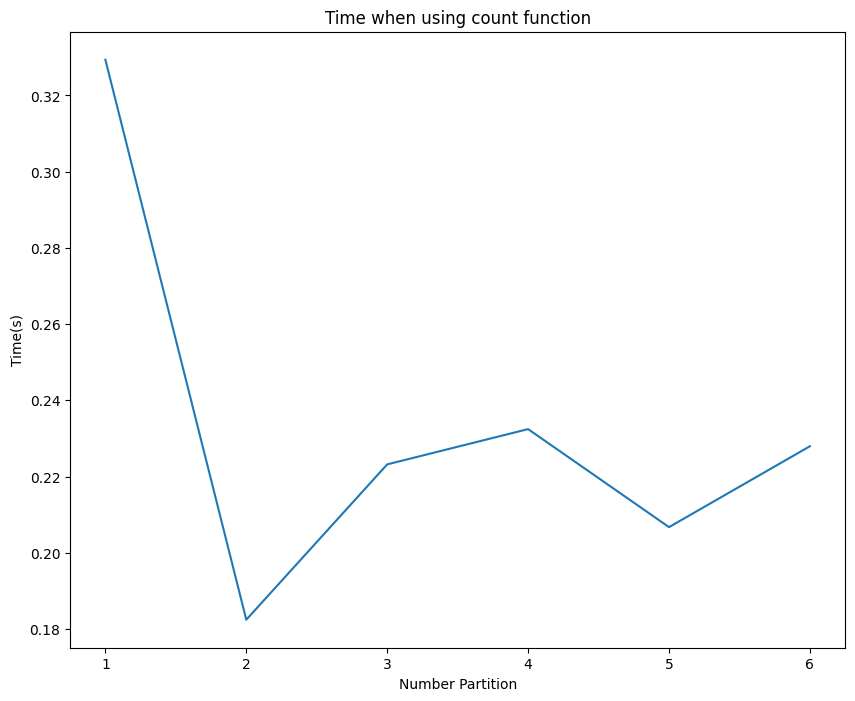

In [0]:
plt.figure(figsize=(10,8))

plt.plot(statistic_df.number_partition, statistic_df["count"])
plt.xlabel("Number Partition")
plt.ylabel("Time(s)")
plt.title("Time when using count function")
plt.show()

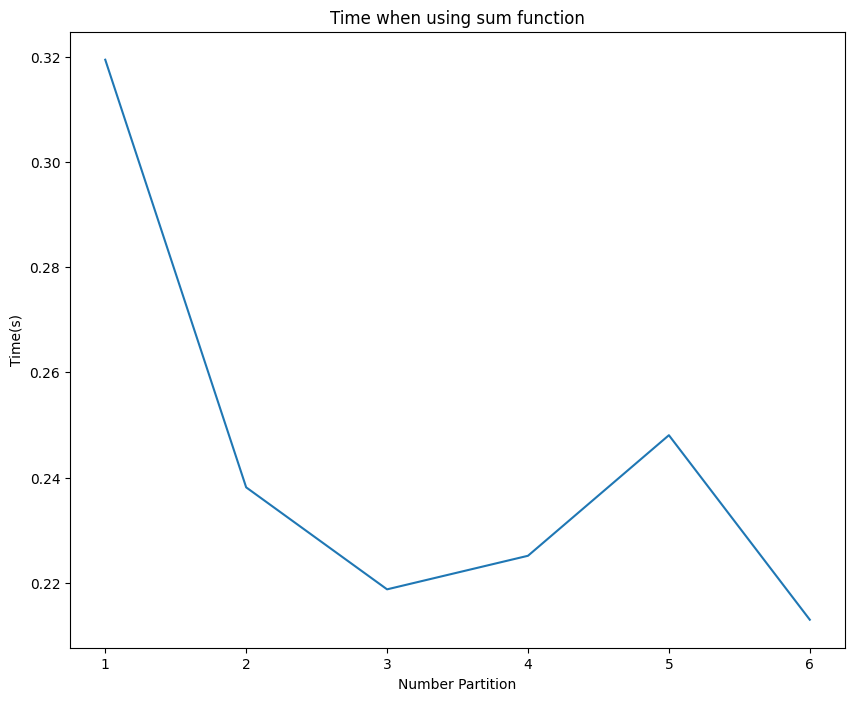

In [0]:
plt.figure(figsize=(10,8))

plt.plot(statistic_df.number_partition, statistic_df["sum"])
plt.xlabel("Number Partition")
plt.ylabel("Time(s)")
plt.title("Time when using sum function")
plt.show()

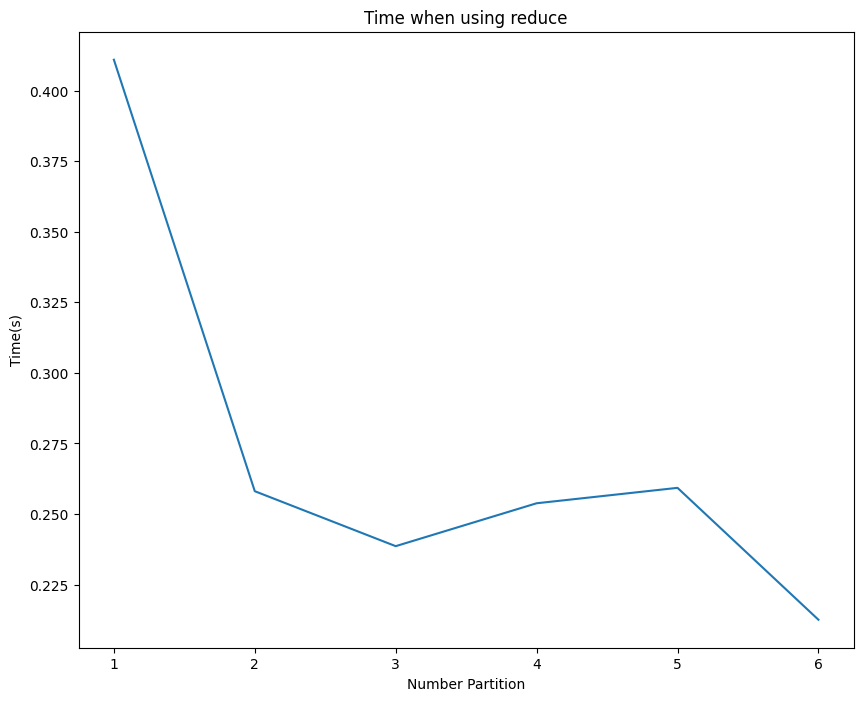

In [0]:
plt.figure(figsize=(10,8))

plt.plot(statistic_df.number_partition, statistic_df.sum_with_reduce)
plt.xlabel("Number Partition")
plt.ylabel("Time(s)")
plt.title("Time when using reduce")
plt.show()

In [0]:
df.agg(sum("value")).collect()[0][-1]

49884985

In [0]:
df.select("value").rdd.map(lambda f:f[-1]).reduce(lambda x,y: x+y)

49884985